# New Section

In [0]:
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import glob

from sklearn.metrics import confusion_matrix,accuracy_score

In [0]:
NCLASSES = 10
HEIGHT = 28
WIDTH = 28
NUM_CHANNELS = 1
BATCH_SIZE = 128

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [0]:
!pip install -q PyDrive


In [5]:
device_name = tf.test.gpu_device_name()
print(device_name)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
!cat /proc/meminfo

/device:GPU:0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15951988886368786401
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 448736249876876405
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1227546709235715654
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14648777152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1894229304354790113
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]
MemTotal:       13333556 kB
MemFree:         9148780 kB
MemAvailable:   11817468 kB
Buffers:           75944 kB
Cached:          2731536 kB
SwapCached:            0 kB
Active:          1279336 kB
Inactive:        2502848 kB
Active(anon):     929972 kB
Inactive(anon):     8532 kB
Active(fil

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [8]:
#importing test images and test.csv
%cd ~/

fileId = '1aL5A_qfzxMSRcQub9BNzt4bIp6cU7QOG'
os.mkdir('dataset')
os.chdir('dataset')

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)

/root
Extracted zip file 1aL5A_qfzxMSRcQub9BNzt4bIp6cU7QOG.zip


In [9]:
#importing test images and test.csv

fileId = '1HNDhP36gC5HfkzPbxUhFv50HI2SQPbrd'

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)

Extracted zip file 1HNDhP36gC5HfkzPbxUhFv50HI2SQPbrd.zip


In [0]:
LIST_OF_LABELS = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

In [0]:
import pandas as pd
train_images = pd.read_csv('/root/dataset/train.csv')


In [13]:
train_images[['id']] = train_images.id.astype(str)
train_images[['label']] = train_images.label.astype(str)

train_images.columns

Index(['id', 'label'], dtype='object')

In [0]:
train_images[['id']] = '/root/dataset/train/' + train_images[['id']] + '.png'
# test_images[['id']] = '/root/dataset/test/' + test_images[['id']] + '.png'

In [15]:
train_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      60000 non-null  object
 1   label   60000 non-null  object
dtypes: object(2)
memory usage: 937.6+ KB


In [44]:
datagen=ImageDataGenerator(rescale=1/255.0, validation_split=0.2)
testgen=ImageDataGenerator(rescale=1/255.0)
train_generator= datagen.flow_from_dataframe(
    dataframe=train_images, directory=None, 
    x_col="id", y_col="label",# classes=LIST_OF_LABELS,
    subset= "training", color_mode='grayscale',
    target_size=(28,28), validate_filenames=False,
    batch_size=32)

valid_generator = datagen.flow_from_dataframe(
    dataframe=train_images, directory=None, 
    x_col="id", y_col="label",# classes=LIST_OF_LABELS,
    subset= "validation", color_mode='grayscale',
    target_size=(28,28), validate_filenames=False,
    batch_size=32)



Found 48000 non-validated image filenames belonging to 10 classes.
Found 12000 non-validated image filenames belonging to 10 classes.


In [83]:

model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same', activation='relu', input_shape=(HEIGHT, HEIGHT, NUM_CHANNELS), kernel_initializer=tf.initializers.GlorotNormal()),
    Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same', activation='relu', kernel_initializer=tf.initializers.GlorotNormal()),
    MaxPooling2D(pool_size=(2,2), strides=2),
    Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same', activation='relu', kernel_initializer=tf.initializers.GlorotNormal()),
    Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same', activation='relu', kernel_initializer=tf.initializers.GlorotNormal()),
    MaxPooling2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax'),
])
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 3136)             

In [0]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(lr=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# model.compile(tf.keras.optimizers.Adam(learning_rate=0.007),
#               tf.keras.losses.categorical_crossentropy(),
#               tf.keras.metrics.Accuracy())

In [19]:
train_generator.n

48000

In [0]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [21]:
STEP_SIZE_VALID
# STEP_SIZE_TRAIN

375

In [22]:
train_generator.batch_size

64

In [85]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEP_SIZE_TRAIN,
        epochs=10,
        validation_data=valid_generator,
        validation_steps=STEP_SIZE_VALID)
# model.save_weights('first_try.h5') 

Epoch 1/10
1500/1500 [==============================] - 18s 12ms/step - loss: 0.4272 - accuracy: 0.8477 - val_loss: 0.2959 - val_accuracy: 0.8934
Epoch 2/10
1500/1500 [==============================] - 18s 12ms/step - loss: 0.2616 - accuracy: 0.9056 - val_loss: 0.2412 - val_accuracy: 0.9085
Epoch 3/10
1500/1500 [==============================] - 18s 12ms/step - loss: 0.2097 - accuracy: 0.9221 - val_loss: 0.2315 - val_accuracy: 0.9122
Epoch 4/10
1500/1500 [==============================] - 19s 12ms/step - loss: 0.1751 - accuracy: 0.9355 - val_loss: 0.2189 - val_accuracy: 0.9187
Epoch 5/10
1500/1500 [==============================] - 18s 12ms/step - loss: 0.1456 - accuracy: 0.9468 - val_loss: 0.1948 - val_accuracy: 0.9299
Epoch 6/10
1500/1500 [==============================] - 19s 12ms/step - loss: 0.1171 - accuracy: 0.9565 - val_loss: 0.2172 - val_accuracy: 0.9267
Epoch 7/10
1500/1500 [==============================] - 18s 12ms/step - loss: 0.0905 - accuracy: 0.9664 - val_loss: 0.2116 -

Text(0.5, 1.0, 'Training and validation loss')

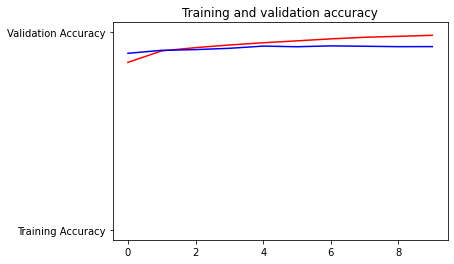

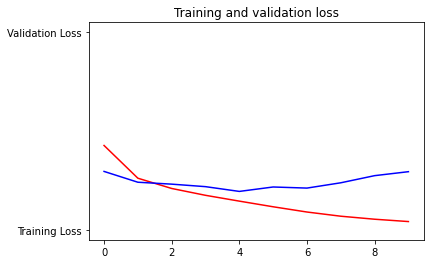

In [86]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

In [87]:
PATH = sorted(glob.glob("/root/dataset/test/*.png"))
print(PATH)

['/root/dataset/test/60001.png', '/root/dataset/test/60002.png', '/root/dataset/test/60003.png', '/root/dataset/test/60004.png', '/root/dataset/test/60005.png', '/root/dataset/test/60006.png', '/root/dataset/test/60007.png', '/root/dataset/test/60008.png', '/root/dataset/test/60009.png', '/root/dataset/test/60010.png', '/root/dataset/test/60011.png', '/root/dataset/test/60012.png', '/root/dataset/test/60013.png', '/root/dataset/test/60014.png', '/root/dataset/test/60015.png', '/root/dataset/test/60016.png', '/root/dataset/test/60017.png', '/root/dataset/test/60018.png', '/root/dataset/test/60019.png', '/root/dataset/test/60020.png', '/root/dataset/test/60021.png', '/root/dataset/test/60022.png', '/root/dataset/test/60023.png', '/root/dataset/test/60024.png', '/root/dataset/test/60025.png', '/root/dataset/test/60026.png', '/root/dataset/test/60027.png', '/root/dataset/test/60028.png', '/root/dataset/test/60029.png', '/root/dataset/test/60030.png', '/root/dataset/test/60031.png', '/root/

In [0]:
images_new = np.empty([1,28,28,1])

for i in range(len(PATH)):
  test_image = tf.keras.preprocessing.image.load_img(PATH[i],  color_mode = "grayscale")
  input_arr = tf.keras.preprocessing.image.img_to_array(test_image)
  input_arr = np.expand_dims(input_arr,axis=0)  # Convert single image to a batch.
  images_new = np.vstack([images_new,input_arr])


In [0]:
images_new = images_new[1:,:]

In [28]:
images_new.shape

(10000, 28, 28, 1)

In [0]:
predictions = model.predict(images_new)

In [0]:
classes = list(np.argmax(predictions, axis=1))

In [0]:
# prediction_list = [LIST_OF_LABELS[classes[j]] for j in range(len(classes))]

In [0]:
test_images = pd.read_csv('/root/dataset/test.csv')

In [0]:
test_images['label'] = classes

In [0]:
test_images.to_csv('Submission_new.csv',index=False)